Source: https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/

# Setting up

In [1]:
import os
import sys
import shutil

import numpy as np

import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf

# progress bar
#  from tqdm import tqdm_notebook

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Checking local devices available

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9649502733169424403, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1468914073
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 477089792665385642
 physical_device_desc: "device: 0, name: GeForce GTX 850M, pci bus id: 0000:01:00.0, compute capability: 5.0"]

In [4]:
GITHUB_PATH = ".."
DL_PATH = os.path.join(GITHUB_PATH, "deep-learning")
SCRAPING_PATH = os.path.join(DL_PATH, "scraping")
GG_PATH = os.path.join(SCRAPING_PATH, "google_images")
IMAGES_PATH = os.path.join(GG_PATH, "download")

DATASET_PATH = os.path.join(DL_PATH, "datasets")

# Train/test split

In [5]:
classes = [dir_ for dir_ in os.listdir(IMAGES_PATH) if dir_ != ".ipynb_checkpoints"]
n_classes = len(classes)

In [6]:
print(classes)
print(n_classes)

['cat', 'dog']
2


In [68]:
def train_test_split(test_ratio=0.2, data_input_path=IMAGES_PATH, data_output_path = DATASET_PATH):
    
    # Creating the train and test folders if they dont exist yer
    train_path ="train"
    test_path = "test"
    paths = [train_path, test_path]
    for path in paths:
        data_path = os.path.join(data_output_path, path)
        if not os.path.exists(data_path):
            print("[MKDIR] {} folder created.".format(path))
            os.makedirs(data_path)
    
    for dir_ in os.listdir(data_input_path):
        if dir_ != ".ipynb_checkpoints":
            print("[{}] starting...".format(dir_))
            
            for path in paths:
                class_path = os.path.join(data_output_path, path, dir_)
                if not os.path.exists(class_path):
                    os.makedirs(class_path)
            
            dir_path = os.path.join(data_input_path, dir_)
            class_img = os.listdir(dir_path).copy()
            np.random.shuffle(class_img)
            train_size = int(len(class_img) * (1 - test_ratio))
            class_train = class_img[:train_size]
            class_test = class_img[train_size:]
            
            dir_path = os.path.join(data_input_path, dir_)
            
            # copy train files
            train_path_ = os.path.join(data_output_path, train_path)
            train_path_dir = os.path.join(train_path_, dir_)
            print("[{}] train copy starting...".format(dir_))
            for img in tqdm_notebook(class_train):
                img_path_src = os.path.join(dir_path, img)
                img_path_dst = os.path.join(train_path_dir, img)
                shutil.copyfile(img_path_src, img_path_dst)
            print("[{}] train copy ended.".format(dir_))
            
            # copy test files
            test_path_ = os.path.join(data_output_path, test_path)
            test_path_dir = os.path.join(test_path_, dir_)
            print("[{}] test copy starting...".format(dir_))
            for img in tqdm_notebook(class_test):
                img_path_src = os.path.join(dir_path, img)
                img_path_dst = os.path.join(test_path_dir, img)
                shutil.copyfile(img_path_src, img_path_dst)
            print("[{}] train copy ended.".format(dir_))
        
    print("All train and test copy files finished.")          
    

In [69]:
# train_test_split()

[MKDIR] train folder created.
[MKDIR] test folder created.
[cat] starting...
[cat] train copy starting...



[cat] train copy ended.
[cat] test copy starting...



[cat] train copy ended.
[dog] starting...
[dog] train copy starting...



[dog] train copy ended.
[dog] test copy starting...



[dog] train copy ended.
All train and test copy files finished.


# Loading pre-trained model

In [7]:
image_size = (139, 139, 3)

In [8]:
from tensorflow.keras.applications import InceptionV3

from tensorflow.keras import models
from tensorflow.keras import layers

In [9]:
inception = InceptionV3(weights='imagenet', include_top=False, input_shape=image_size)

# Freeze the required layers

In [10]:
n_layer_free = 1

# Freeze the layers except the last 4 layers
for layer in inception.layers[:-n_layer_free]:
    layer.trainable = False

# Create a new model

In [14]:
# Create the model
model = models.Sequential()

In [15]:
# Add the vgg convolutional base model
model.add(inception)

In [16]:
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(n_classes, activation='softmax'))

In [17]:
 # Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 26,522,146
Trainable params: 4,719,362
Non-trainable params: 21,802,784
_________________________________________________________________


# Setup the data generators

In [18]:
train_dir = os.path.join(DATASET_PATH, "train")
test_dir = os.path.join(DATASET_PATH, "test")

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [28]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 

In [29]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [30]:
# Change the batchsize according to your system RAM
train_batchsize = 10
test_batchsize = 2

In [36]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size[0], image_size[1]),
        batch_size=train_batchsize,
        color_mode="rgb",
        class_mode='categorical')

Found 668 images belonging to 2 classes.


In [37]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size[0], image_size[1]),
        batch_size=test_batchsize,
        class_mode='categorical',
        color_mode="rgb",
        shuffle=False)

Found 169 images belonging to 2 classes.


# Train the model

In [38]:
from tensorflow.keras import optimizers

In [39]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

In [40]:
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples//train_generator.batch_size ,
      epochs=30,
      validation_data=test_generator,
      validation_steps=test_generator.samples//test_generator.batch_size,
      verbose=1)

Epoch 1/30
50/66 [=====================>........] - ETA: 4s - loss: 4.9773 - acc: 0.5420  ETA: 12

C:\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


66/66 [==============================] - 23s 349ms/step - loss: 4.4532 - acc: 0.5682 - val_loss: 1.5064 - val_acc: 0.8571
Epoch 2/30
66/66 [==============================] - 21s 321ms/step - loss: 1.1652 - acc: 0.7144 - val_loss: 0.8532 - val_acc: 0.8810
Epoch 3/30
66/66 [==============================] - 20s 310ms/step - loss: 0.7043 - acc: 0.6837 - val_loss: 0.3845 - val_acc: 0.8452
Epoch 4/30
66/66 [==============================] - 20s 306ms/step - loss: 0.5478 - acc: 0.7398 - val_loss: 0.5324 - val_acc: 0.8750
Epoch 5/30
66/66 [==============================] - 20s 310ms/step - loss: 0.5301 - acc: 0.7329 - val_loss: 0.4359 - val_acc: 0.8810
Epoch 6/30
66/66 [==============================] - 20s 297ms/step - loss: 0.5114 - acc: 0.7560 - val_loss: 0.4288 - val_acc: 0.8750
Epoch 7/30
66/66 [==============================] - 20s 309ms/step - loss: 0.5119 - acc: 0.7481 - val_loss: 0.5417 - val_acc: 0.8988
Epoch 8/30
66/66 [==============================] - 20s 308ms/step - loss: 0.534

In [ ]:
# Save the model
model.save('griezmann_messi_v1.h5')

# Check performance

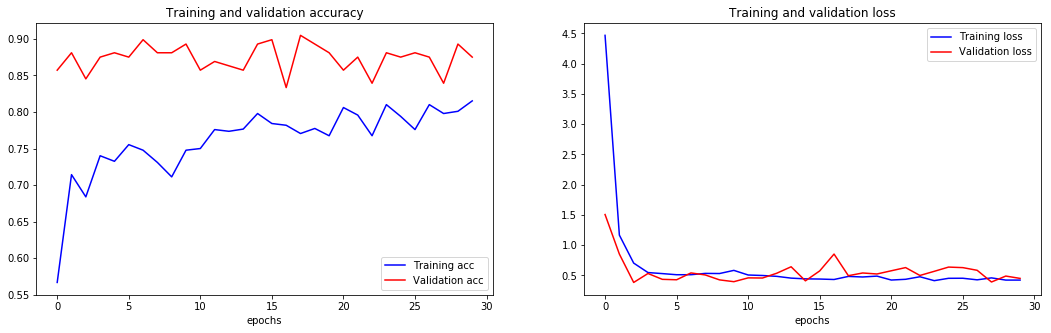

In [42]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

plt.figure(figsize=(18,5))

plt.subplot(121)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("epochs")
plt.legend() 
plt.subplot(122)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("epochs")
plt.legend()
 
plt.show()

In [43]:
from sklearn.metrics import classification_report, confusion_matrix

In [44]:
def normalize_conf_mx(conf_mx):
    row_sums = conf_mx.sum(axis=1, keepdims=True)
    norm_conf_mx = conf_mx / row_sums
    return norm_conf_mx

In [45]:
def show_confusion_matrix(true_label, pred_labels):

    # Create the absolute and the normalized confusion matrix
    conf_mx = confusion_matrix(true_label, pred_labels)
    norm_conf_mx = normalize_conf_mx(conf_mx)
    
    # Plot matrix
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(121)
    ax1.set_title("Absolute confusion matrix")
    cax1 = ax1.matshow(conf_mx)
    fig.colorbar(cax1)
    ax2 = fig.add_subplot(122)
    ax2.set_title("Normalized confusion matrix")
    cax2 = ax2.matshow(norm_conf_mx)
    fig.colorbar(cax2)
    plt.show()

In [50]:
Y_pred = model.predict_generator(test_generator, test_generator.samples/test_generator.batch_size, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

85/84 [==============================] - 4s 51ms/step


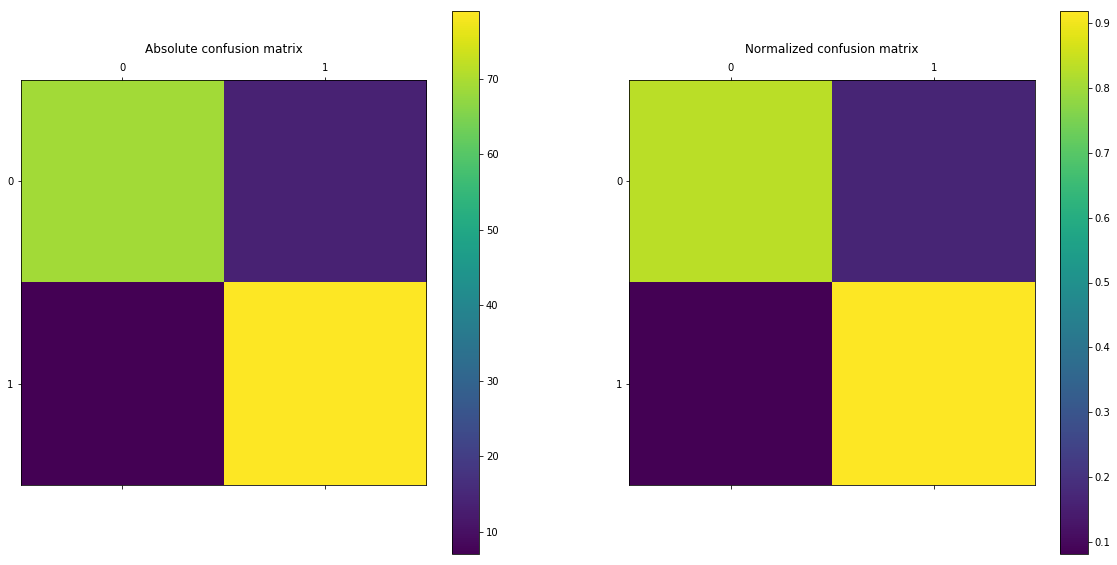

In [52]:
show_confusion_matrix(test_generator.classes, y_pred)

In [53]:
target_names = classes
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

             precision    recall  f1-score   support

        cat       0.91      0.83      0.87        83
        dog       0.85      0.92      0.88        86

avg / total       0.88      0.88      0.88       169

